# Tests for pylenspice

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import astropy.io.fits as fits
import astropy.coordinates
import astropy.units

import os
import sys
import importlib
import collections

import pylenspice

import treecorr

pi = np.pi

In [ ]:
importlib.reload(pylenspice)

## Test rotation angle

Only "unit test" in here. Shame on me...

In [2]:
n = 1000
ra = np.random.rand(n)*2*pi
dec = np.random.rand(n)*pi - pi/2

coords = astropy.coordinates.ICRS(ra=ra*astropy.units.rad, dec=dec*astropy.units.rad,
                                      pm_ra=np.ones(n)*astropy.units.mas/astropy.units.year, pm_dec=np.zeros(n)*astropy.units.mas/astropy.units.year,
                                      differential_cls=astropy.coordinates.SphericalDifferential)
new_coords = coords.transform_to(astropy.coordinates.Galactic)
pole_coords = astropy.coordinates.ICRS(ra=0*astropy.units.rad, dec=pi/2*astropy.units.rad)
new_pole_coords = pole_coords.transform_to(astropy.coordinates.Galactic)

phi = -np.arctan2(new_coords.pm_b, new_coords.pm_l_cosb)/astropy.units.rad%(2*pi)

l2, b2, phi2 = pylenspice.cel2gal(ra*180/pi, dec*180/pi)

# print("l :", new_coords.l.deg)
# print("b :", new_coords.b.deg)
# print("phi :", phi)
# print("l :", l2)
# print("b :", b2)
# print("phi :", phi2)
assert(np.allclose(new_coords.l.deg, l2))
assert(np.allclose(new_coords.b.deg, b2))
assert(np.allclose(phi, phi2))

## Make MiraTitan catalogues

### MT lens catalogue.

Find peaks in high-resolution kappa map from MiraTitan.

In [ ]:
m = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new.fits")

threshold = 0.2

peak_idx = np.where(m>threshold)[0]
print("# peaks: {}".format(len(peak_idx)))

true_peak_idx = []
for i, idx in enumerate(peak_idx):
    neighbours = hp.get_all_neighbours(8192, idx)
    if np.all(m[idx] > m[neighbours]):
        true_peak_idx.append(idx)
        
print("# true peaks: {}".format(len(true_peak_idx)))
     

ra_lens, dec_lens = hp.pix2ang(8192, true_peak_idx, lonlat=True)
k = m[true_peak_idx]

for name, cut in [("no_cut", dec_lens > 0),
                  ("low_dec", dec_lens < 40),
                  ("high_dec", dec_lens > 40)]:
    mask = cut
    
    # Write to file
    output_filename = "/data/tilman/polspice/pylenspice/example/data/MT/cat/oct_{}.fits".format(name)

    primaryheader = fits.Header()
    primaryhdu = fits.PrimaryHDU(header=primaryheader)
    datahdu = fits.BinTableHDU.from_columns([fits.Column(name="x", format="D", array=ra_lens[mask]),
                                            fits.Column(name="y", format="D", array=dec_lens[mask]),
                                            fits.Column(name="val", format="E", array=k[mask]),])
    hdu = fits.HDUList([primaryhdu, datahdu])
    hdu.writeto(output_filename, overwrite=True)
    
    # Transform to galactic coordinates
    l, b, _ = pylenspice.cel2gal(ra_lens[mask], dec_lens[mask])

    # Write to file
    output_filename = "/data/tilman/polspice/pylenspice/example/data/MT/cat/galactic/oct_{}.fits".format(name)

    primaryheader = fits.Header()
    primaryhdu = fits.PrimaryHDU(header=primaryheader)
    datahdu = fits.BinTableHDU.from_columns([fits.Column(name="x", format="D", array=l),
                                            fits.Column(name="y", format="D", array=b),
                                            fits.Column(name="val", format="E", array=k[mask]),])
    hdu = fits.HDUList([primaryhdu, datahdu])
    hdu.writeto(output_filename, overwrite=True)

del m

### MT shear catalogue

In [ ]:
hdu = fits.open("/data/tilman/MiraTitan/MT_KiDS_tomo4_1.493GpAM_allz_ra_dec_e1_e2_w_z_lmax32768_interp_new.fits")

ra = hdu[1].data["ra_arcmin"]
dec = hdu[1].data["dec_arcmin"]

n_gal = 2000000
selection = np.random.choice(ra.size, n_gal, replace=False)

ra = ra[selection]
dec = dec[selection]

e1 = hdu[1].data["shear1"][selection]
e2 = hdu[1].data["shear2"][selection]

hdu.close()

for name, cut in [("no_cut", dec > 0),
                  ("low_dec", dec < 40),
                  ("high_dec", dec > 40)]:
    print("Processing {}.".format(name))
    mask = cut

    # Write to file
    output_filename = "/data/tilman/polspice/pylenspice/example/data/shear/MT/cat/oct_{}.fits".format(name)

    primaryheader = fits.Header()
    primaryhdu = fits.PrimaryHDU(header=primaryheader)
    datahdu = fits.BinTableHDU.from_columns([fits.Column(name="x", format="D", array=ra[mask]),
                                            fits.Column(name="y", format="D", array=dec[mask]),
                                            fits.Column(name="e1", format="E", array=e1[mask]),
                                            fits.Column(name="e2", format="E", array=e2[mask])])
    hdu = fits.HDUList([primaryhdu, datahdu])
    hdu.writeto(output_filename, overwrite=True)
    
    # Transform to galactic coordinates
    l, b, e1_gal, e2_gal = pylenspice.convert_shear_to_galactic_coordinates(ra[mask], dec[mask], 
                                                                            e1[mask], e2[mask])
    # Write to file
    output_filename = "/data/tilman/polspice/pylenspice/example/data/shear/MT/cat/galactic/oct_{}.fits".format(name)

    primaryheader = fits.Header()
    primaryhdu = fits.PrimaryHDU(header=primaryheader)
    datahdu = fits.BinTableHDU.from_columns([fits.Column(name="x", format="D", array=l),
                                            fits.Column(name="y", format="D", array=b),
                                            fits.Column(name="e1", format="E", array=e1_gal),
                                            fits.Column(name="e2", format="E", array=e2_gal)])
    hdu = fits.HDUList([primaryhdu, datahdu])
    hdu.writeto(output_filename, overwrite=True)

## Calcualte correlation functions for MiraTitan

In [ ]:
lens_path = "/data/tilman/polspice/pylenspice/example/data/MT/cat/"
source_path = "/data/tilman/polspice/pylenspice/example/data/shear/MT/cat/"

lens_cat = {}
source_cat = {}
corr = {}

for key, file in [("cel", "oct_no_cut.fits"),
                  ("gal", "galactic/oct_no_cut.fits"),
                  ("cel-low-dec", "oct_low_dec.fits"),
                  ("gal-low-dec", "galactic/oct_low_dec.fits"),
                  ("cel-high-dec", "oct_high_dec.fits"),
                  ("gal-high-dec", "galactic/oct_high_dec.fits"),]:
    print("Processing {}.".format(key))
    lens_cat[key] = treecorr.Catalog(file_name=os.path.join(lens_path, file),
                                     ra_col="x", ra_units="deg",
                                     dec_col="y", dec_units="deg",
                                     k_col="val")

    source_cat[key] = treecorr.Catalog(file_name=os.path.join(source_path, file),
                                       ra_col="x", ra_units="deg",
                                       dec_col="y", dec_units="deg",
                                       g1_col="e1",
                                       g2_col="e2",
                                       flip_g2=True)
    
    corr[key] = treecorr.KGCorrelation(nbins=100, 
                                       min_sep=1/60,
                                       max_sep=6,
                                       sep_units="deg",
                                       bin_slop=0,
                                       verbose=2,
                                       output_dots=True)

    corr[key].process(lens_cat[key], source_cat[key], num_threads=40)

## Plot correlation functions

Text(0.5,0.98,'MiraTitan tangential shear')

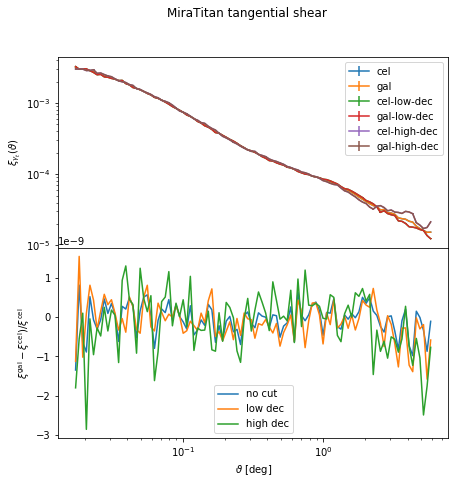

In [4]:
fig, plots = plt.subplots(2, 1, sharex=True, figsize=(7, 7))
fig.subplots_adjust(hspace=0)

for key in ["cel", "gal", 
            "cel-low-dec", "gal-low-dec", 
            "cel-high-dec", "gal-high-dec"]:
    plots[0].errorbar(corr[key].meanr, -corr[key].xi, np.sqrt(corr[key].varxi), label=key)
    
plots[0].legend()
plots[0].set_xscale("log")
plots[0].set_yscale("log")
plots[0].set_ylabel(r"$\xi_{\gamma_t}(\vartheta)$")

plots[1].semilogx(corr["cel"].meanr, corr["gal"].xi/corr["cel"].xi-1, label="no cut")
plots[1].semilogx(corr["cel-low-dec"].meanr, corr["gal-low-dec"].xi/corr["cel-low-dec"].xi-1, label="low dec")
plots[1].semilogx(corr["cel-high-dec"].meanr, corr["gal-high-dec"].xi/corr["cel-high-dec"].xi-1, label="high dec")

plots[1].legend()
plots[1].set_xlabel(r"$\vartheta$ [deg]")
plots[1].set_ylabel(r"$\xi^\mathrm{gal}-\xi^\mathrm{cel})/\xi^\mathrm{cel}$")

fig.suptitle("MiraTitan tangential shear")

## Make MiraTitan HEALPix maps

In [ ]:
nside = 2048

### MiraTitan peak maps

In [ ]:
for galactic in [True, False]:
    hdu = astropy.io.fits.open("/data/tilman/polspice/pylenspice/example/data/MT/cat/{}oct_no_cut.fits".format("galactic/" if galactic else ""))

    pixel_idx = hp.ang2pix(nside, -hdu[1].data["y"]/180*pi+pi/2, hdu[1].data["x"]/180*pi)

    peak_map = np.zeros(hp.nside2npix(nside))
    np.add.at(peak_map, pixel_idx, 1)

    peak_map_file_name = "/data/tilman/polspice/pylenspice/example/data/MT/{}2048/peak/peak_map.fits".format("galactic/" if galactic else "")
    hp.write_map(peak_map_file_name, peak_map, overwrite=True)
    
    MT_peak_map = {"file": peak_map_file_name, "field" : 0}
    MT_mask = [{"file": "/data/tilman/MiraTitan/okappa_2.9412_new_2048{}_mask.fits".format("_galactic" if galactic else ""), "field" : 0}]

    output_path = "/data/tilman/polspice/pylenspice/example/data/MT/{}2048/peak/".format("galactic/" if galactic else "")

    MT_output_filenames = { "triplet" : os.path.join(output_path, "MT_peak_triplet.fits"),
                             "doublet_mask" : os.path.join(output_path, "MT_peak_doublet_mask.fits"),
                             "singlet_mask" : os.path.join(output_path, "MT_peak_singlet_mask.fits")}

    footprint_file = "/data/tilman/polspice/pylenspice/example/data/shear/MT/{}2048/doublet_mask.fits".format("galactic/" if galactic else "")

    pylenspice.create_foreground_healpix_triplet(MT_peak_map, MT_mask, MT_output_filenames, nside, 
                                                 coord_in=("G" if galactic else "C"), coord_out=("G" if galactic else "C"), 
                                                 footprint_file=footprint_file
                                                )


### MiraTitan shear maps

In [ ]:
for galactic in [True, False]:
    MT_column_names = {"x" : "ra_arcmin",
                       "y" : "dec_arcmin",
                       "e1": "shear1",
                       "e2": "shear2",
                       "w" : "lensfit_w"}

    MT_selection = [("lensfit_w", "gt", 0.0),]

    shear_catalogs = ["/data/tilman/MiraTitan/MT_KiDS_tomo4_1.493GpAM_allz_ra_dec_e1_e2_w_z_lmax32768_interp_new.fits"]

    shear_healpix_path = "/data/tilman/polspice/pylenspice/example/data/shear/MT/{}2048/".format("galactic/" if galactic else "")

    shear_output_filenames = {"triplet" :        os.path.join(shear_healpix_path, "triplet.fits"),
                              "singlet_mask" :   os.path.join(shear_healpix_path, "singlet_mask.fits"),
                              "doublet_mask" :   os.path.join(shear_healpix_path, "doublet_mask.fits"),
                              "doublet_weight" : os.path.join(shear_healpix_path, "doublet_weight.fits")}

    pylenspice.create_shear_healpix_triplet(shear_catalogs=shear_catalogs, out_filenames=shear_output_filenames, 
                                            hdu_idx=1, nside=nside, flip_e1=False, 
                                            convert_to_galactic=galactic, partial_maps=True, 
                                            c_correction="none", m_correction="none", column_names=MT_column_names, 
                                            selections=MT_selection)

### MiraTitan kappa maps

In [ ]:
nside_HR = 8192

print("Reading map.")
m = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new.fits")

mask_idx = np.where(m != 0)[0]
print("Getting pixel coordinates.")
theta, phi = hp.pix2ang(nside_HR, mask_idx)
print("Creating coordinate frame.")
skycoords = astropy.coordinates.ICRS(ra=phi*astropy.units.rad, dec=(-theta+pi/2)*astropy.units.rad)
del theta, phi
print("Transforming coordinate frame.")
skycoords = skycoords.transform_to(astropy.coordinates.Galactic)
print("Getting pixel indices.")
gal_idx = hp.ang2pix(nside_HR, -skycoords.b.rad+pi/2, skycoords.l.rad)
del skycoords

m_gal = np.zeros(hp.nside2npix(nside_HR), dtype=np.float32)

print("Adding up.")
np.add.at(m_gal, gal_idx, m[mask_idx])

hp.write_map("/data/tilman/MiraTitan/okappa_2.9412_new_{}_galactic_no_intp.fits".format(nside_HR), m_gal, overwrite=True)

In [ ]:
# And downsample
m = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new.fits")
m_gal = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_8192_galactic_no_intp.fits")

m_gal = hp.ud_grade(m_gal, 2048)
m = hp.ud_grade(m, 2048)

hp.write_map("/data/tilman/MiraTitan/okappa_2.9412_new_{}_galactic_no_intp.fits".format(2048), m_gal, overwrite=True)
hp.write_map("/data/tilman/MiraTitan/okappa_2.9412_new_{}.fits".format(2048), m, overwrite=True)

del m, m_gal

### Transform kappa map to galactic coordinates (low-res, interpolation)

In [ ]:
MT_kappa_map = {"file": "/data/tilman/MiraTitan/okappa_2.9412_new_2048.fits", "field" : 0}
MT_mask = [{"file": "/data/tilman/MiraTitan/okappa_2.9412_new_2048_mask.fits", "field" : 0}]

output_path = "/data/tilman/polspice/pylenspice/example/data/MT/galactic/2048/intp/"

MT_output_filenames = { "triplet" : os.path.join(output_path, "MT_kappa_triplet.fits"),
                         "doublet_mask" : os.path.join(output_path, "MT_kappa_doublet_mask.fits"),
                         "singlet_mask" : os.path.join(output_path, "MT_kappa_singlet_mask.fits")}

footprint_file = "/data/tilman/polspice/pylenspice/example/data/shear/MT/galactic/2048/doublet_mask.fits"

pylenspice.create_foreground_healpix_triplet(MT_kappa_map, MT_mask, MT_output_filenames, nside, 
                                             coord_in="C", coord_out="G", 
                                             footprint_file=footprint_file
                                            )


In [ ]:
for galactic in [True, False]:    
    MT_kappa_map = {"file": "/data/tilman/MiraTitan/okappa_2.9412_new_2048{}.fits".format("_galactic_no_intp" if galactic else ""), "field" : 0}
    MT_mask = [{"file": "/data/tilman/MiraTitan/okappa_2.9412_new_2048{}_mask.fits".format("_galactic" if galactic else ""), "field" : 0}]

    output_path = "/data/tilman/polspice/pylenspice/example/data/MT/{}2048/".format("galactic/" if galactic else "")

    MT_output_filenames = { "triplet" : os.path.join(output_path, "MT_kappa_triplet.fits"),
                             "doublet_mask" : os.path.join(output_path, "MT_kappa_doublet_mask.fits"),
                             "singlet_mask" : os.path.join(output_path, "MT_kappa_singlet_mask.fits")}

    footprint_file = "/data/tilman/polspice/pylenspice/example/data/shear/MT/{}2048/doublet_mask.fits".format("galactic/" if galactic else "")

    pylenspice.create_foreground_healpix_triplet(MT_kappa_map, MT_mask, MT_output_filenames, nside, 
                                                 coord_in=("G" if galactic else "C"), coord_out=("G" if galactic else "C"), 
                                                 footprint_file=footprint_file
                                                )


## Calculate power spectrum with PolSpice

In [5]:
polspice_path = "/home/tilman/lib/polspice/PolSpice_v03-04-01/src/spice"

### Peaks

In [ ]:
for galactic in [True, False]:
    s = "galactic/" if galactic else ""

    shear_healpix_path = "/data/tilman/polspice/pylenspice/example/data/shear/MT/{}2048/".format(s)
    peak_path = "/data/tilman/polspice/pylenspice/example/data/MT/{}2048/peak/".format(s)

    cl_path = "/data/tilman/polspice/pylenspice/example/results/MT/{}2048/peak/".format(s)

    params={"mapfile" : os.path.join(shear_healpix_path, "triplet.fits"),
            "maskfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
            "maskfilep" : os.path.join(shear_healpix_path, "doublet_mask.fits"),
            "weightfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
            "weightfilep" : os.path.join(shear_healpix_path, "doublet_weight.fits"),
            "mapfile2" : os.path.join(peak_path, "MT_peak_triplet.fits"),
            "maskfile2" : os.path.join(peak_path, "MT_peak_singlet_mask.fits"),
            "polarization" : "YES",
            "thetamax" : 60.0,
            "apodizesigma" : 60.0,
            "clfile" : os.path.join(cl_path, "spice.cl"),
            "corfile" : os.path.join(cl_path, "spice.corr"),
            "kernelsfileout" : os.path.join(cl_path, "spice.kernels"),
            "nlmax" : 3000,
            "decouple" : "NO",
            "verbosity" : 2}
    pylenspice.run_polspice(polspice_path, **params)

### Kappa

In [ ]:
for galactic in [True, False]:
    s = "galactic/" if galactic else ""
    shear_healpix_path = "/data/tilman/polspice/pylenspice/example/data/shear/MT/{}2048/".format(s)
    
    for s2 in ["", 
               "intp/"]:
        if not galactic and s2 != "":
            continue
            
        kappa_path = "/data/tilman/polspice/pylenspice/example/data/MT/{}2048/{}".format(s, s2)

        cl_path = "/data/tilman/polspice/pylenspice/example/results/MT/{}2048/{}".format(s, s2)

        params={"mapfile" : os.path.join(shear_healpix_path, "triplet.fits"),
                "maskfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
                "maskfilep" : os.path.join(shear_healpix_path, "doublet_mask.fits"),
                "weightfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
                "weightfilep" : os.path.join(shear_healpix_path, "doublet_weight.fits"),
                "mapfile2" : os.path.join(kappa_path, "MT_kappa_triplet.fits"),
                "maskfile2" : os.path.join(kappa_path, "MT_kappa_singlet_mask.fits"),
                "polarization" : "YES",
                "thetamax" : 60.0,
                "apodizesigma" : 60.0,
                "clfile" : os.path.join(cl_path, "spice.cl"),
                "corfile" : os.path.join(cl_path, "spice.corr"),
                "kernelsfileout" : os.path.join(cl_path, "spice.kernels"),
                "nlmax" : 3000,
                "decouple" : "NO",
                "verbosity" : 2}
        pylenspice.run_polspice(polspice_path, **params)

## Plot peak power spectra

Text(0.5,0.98,'MiraTitan shear x peaks nside 2048 gal vs cel coords')

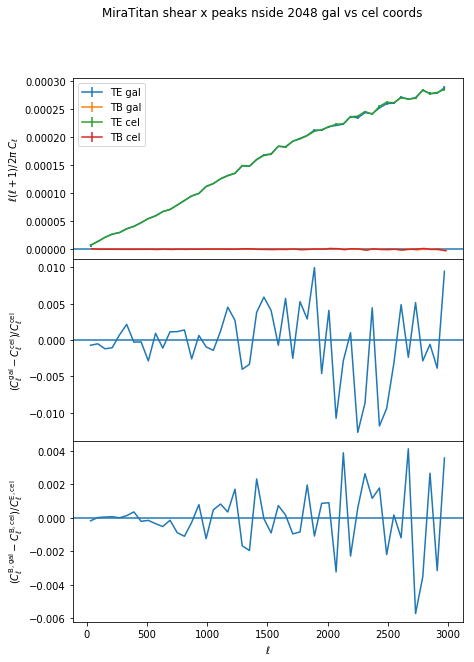

In [8]:
cl_path = "/data/tilman/polspice/pylenspice/example/results/MT/"

n_bin = 50
ell_min = 1
ell_max = 3000

Cl_TE = collections.OrderedDict()
Cl_TB = collections.OrderedDict()
Cl_TE_binned = collections.OrderedDict()
Cl_TB_binned = collections.OrderedDict()
Cl_TE_binned_err = collections.OrderedDict()
Cl_TB_binned_err = collections.OrderedDict()

fig, plots = plt.subplots(3, 1, sharex=True, figsize=(7, 10))
fig.subplots_adjust(hspace=0)

for file, name in [(os.path.join(cl_path, "galactic/2048/peak/spice.cl"), "gal"),
                   (os.path.join(cl_path, "2048/peak/spice.cl"), "cel"),]:
    ell, Cl_TE[name], Cl_TB[name] = np.loadtxt(file, unpack=True, usecols=[0,7,8])

    Cl_TE_binned[name], Cl_TE_binned_err[name], binned_ell = pylenspice.bin_Cl(ell, Cl_TE[name], n_bin, ell_min, ell_max)
    Cl_TB_binned[name], Cl_TB_binned_err[name], binned_ell = pylenspice.bin_Cl(ell, Cl_TB[name], n_bin, ell_min, ell_max)

    units = binned_ell*(binned_ell+1)/(2*pi)

    plots[0].errorbar(binned_ell, units*Cl_TE_binned[name], units*Cl_TE_binned_err[name], label="TE {}".format(name))
    plots[0].errorbar(binned_ell+10, units*Cl_TB_binned[name], units*Cl_TB_binned_err[name], label="TB {}".format(name))

plots[0].axhline()
plots[0].legend()
plots[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$")

plots[1].plot(binned_ell, Cl_TE_binned["gal"]/Cl_TE_binned["cel"]-1)
plots[1].set_ylabel(r"$(C_\ell^\mathrm{gal}-C_\ell^\mathrm{cel})/C_\ell^\mathrm{cel}$")
plots[1].axhline()

plots[2].plot(binned_ell, (Cl_TB_binned["gal"]-Cl_TB_binned["cel"])/Cl_TE_binned["cel"])
plots[2].set_xlabel(r"$\ell$")
plots[2].set_ylabel(r"$(C_\ell^\mathrm{B,gal}-C_\ell^\mathrm{B,cel})/C_\ell^\mathrm{E,cel}$")
plots[2].axhline()

fig.suptitle("MiraTitan shear x peaks nside 2048 gal vs cel coords")


## Plot kappa power spectrum

Text(0.5,0.98,'MiraTitan shear x kappa nside 2048 gal vs cel coords')

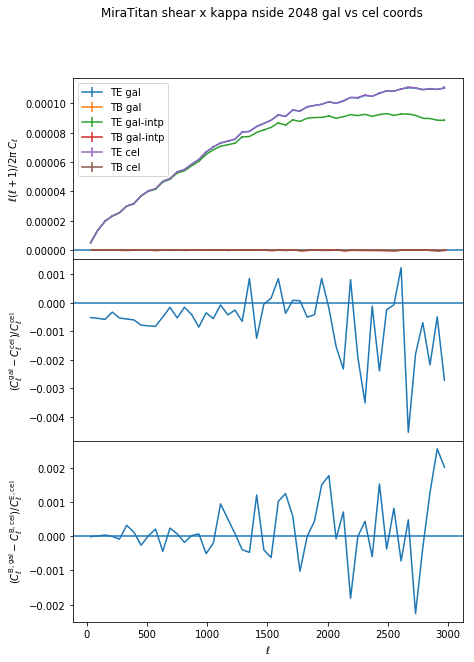

In [9]:
cl_path = "/data/tilman/polspice/pylenspice/example/results/MT/"

n_bin = 50
ell_min = 1
ell_max = 3000

Cl_TE = collections.OrderedDict()
Cl_TB = collections.OrderedDict()
Cl_TE_binned = collections.OrderedDict()
Cl_TB_binned = collections.OrderedDict()
Cl_TE_binned_err = collections.OrderedDict()
Cl_TB_binned_err = collections.OrderedDict()

fig, plots = plt.subplots(3, 1, sharex=True, figsize=(7, 10))
fig.subplots_adjust(hspace=0)

for file, name in [(os.path.join(cl_path, "galactic/2048/spice.cl"), "gal"),
                   (os.path.join(cl_path, "galactic/2048/intp/spice.cl"), "gal-intp"),
                   (os.path.join(cl_path, "2048/spice.cl"), "cel"),]:
    ell, Cl_TE[name], Cl_TB[name] = np.loadtxt(file, unpack=True, usecols=[0,7,8])

    Cl_TE_binned[name], Cl_TE_binned_err[name], binned_ell = pylenspice.bin_Cl(ell, Cl_TE[name], n_bin, ell_min, ell_max)
    Cl_TB_binned[name], Cl_TB_binned_err[name], binned_ell = pylenspice.bin_Cl(ell, Cl_TB[name], n_bin, ell_min, ell_max)

    units = binned_ell*(binned_ell+1)/(2*pi)

    plots[0].errorbar(binned_ell, units*Cl_TE_binned[name], units*Cl_TE_binned_err[name], label="TE {}".format(name))
    plots[0].errorbar(binned_ell+10, units*Cl_TB_binned[name], units*Cl_TB_binned_err[name], label="TB {}".format(name))

plots[0].axhline()
plots[0].legend()
plots[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$")

plots[1].plot(binned_ell, Cl_TE_binned["gal"]/Cl_TE_binned["cel"]-1)
plots[1].set_ylabel(r"$(C_\ell^\mathrm{gal}-C_\ell^\mathrm{cel})/C_\ell^\mathrm{cel}$")
plots[1].axhline()

plots[2].plot(binned_ell, (Cl_TB_binned["gal"]-Cl_TB_binned["cel"])/Cl_TE_binned["cel"])
plots[2].set_xlabel(r"$\ell$")
plots[2].set_ylabel(r"$(C_\ell^\mathrm{B,gal}-C_\ell^\mathrm{B,cel})/C_\ell^\mathrm{E,cel}$")
plots[2].axhline()

fig.suptitle("MiraTitan shear x kappa nside 2048 gal vs cel coords")


### Kappa histogram

In [ ]:
# m = hp.read_map("/data/tilman/polspice/pylenspice/example/data/shear/MT/2048/triplet.fits", hdu=2)
# m_gal = hp.read_map("/data/tilman/polspice/pylenspice/example/data/shear/MT/galactic/2048/triplet.fits", hdu=2)

m = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048.fits")
m_gal = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_galactic.fits")

mask = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_mask.fits").astype(bool)
mask_gal = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_galactic_mask.fits").astype(bool)

b = plt.hist(m[mask], bins=np.linspace(-0.1, 0.3, 100), histtype="step")
b = plt.hist(m_gal[mask_gal], bins=np.linspace(-0.1, 0.3, 100), histtype="step")
plt.yscale("log")

plt.xlabel(r"$\kappa$")
plt.title("MiraTitan kappa map nside 2048 gal vs cel coords")
#plt.savefig("/data/tilman/polspice/pylenspice/example/results/plots/MT_kappa_hist.png")

### Kappa masks

They really should match...

In [ ]:
m = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048.fits")
m_gal = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_galactic_no_intp.fits")

mask = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_mask.fits").astype(bool)
mask_gal = hp.read_map("/data/tilman/MiraTitan/okappa_2.9412_new_2048_galactic_mask.fits").astype(bool)


In [ ]:
print(np.count_nonzero(m))
print(np.count_nonzero(m_gal))
print(np.sum(mask))
print(np.sum(mask_gal))